<a href="https://colab.research.google.com/github/ClaudioAMF1/Machine-Learning/blob/main/sentiment_Claudio_Meireles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Carregando o dataset IMDB...


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



Primeiras linhas do dataset:
                                              review  sentiment
0  This was an absolutely terrible movie. Don't b...          0
1  I have been known to fall asleep during films,...          0
2  Mann photographs the Alberta Rocky Mountains i...          0
3  This is the kind of film for a snowy Sunday af...          1
4  As others have mentioned, all the women that g...          1

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None

Distribuição de sentimentos:
sentiment
1    2526
0    2474
Name: count, dtype: int64

Análise de Sentimentos com Hugging Face:

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...
Se

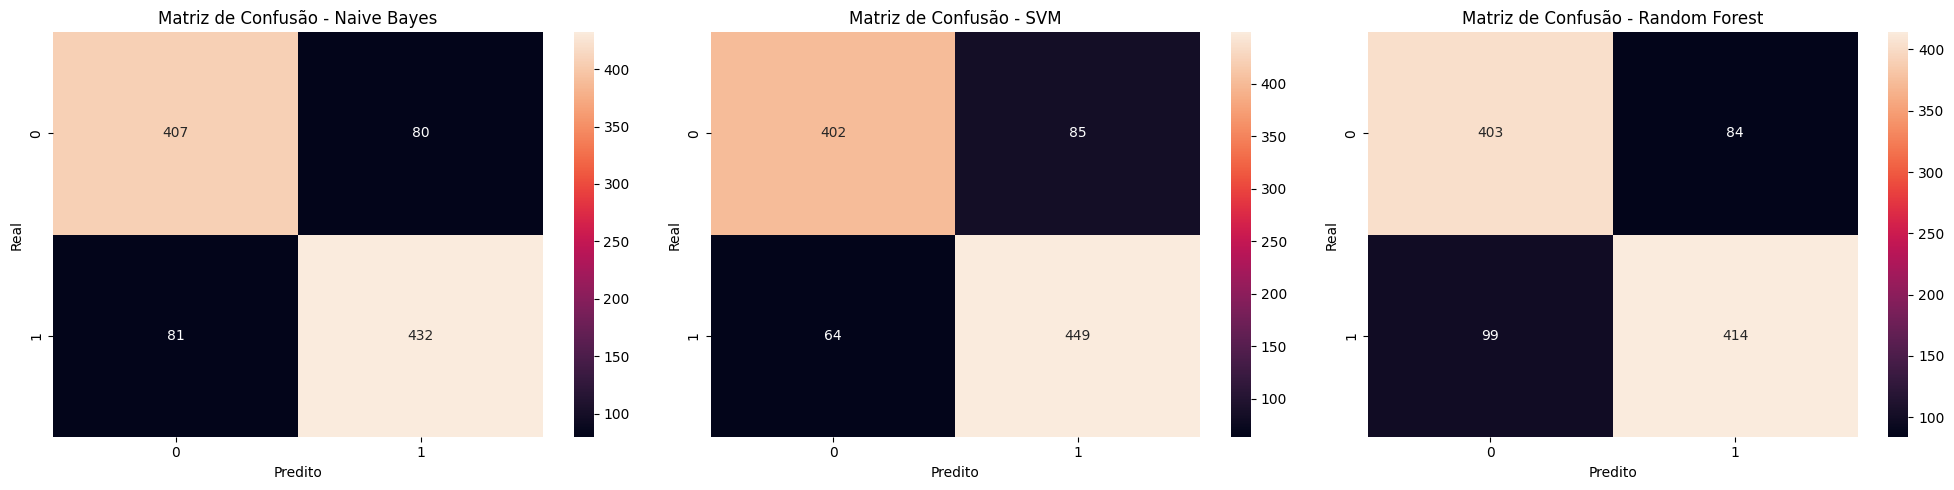

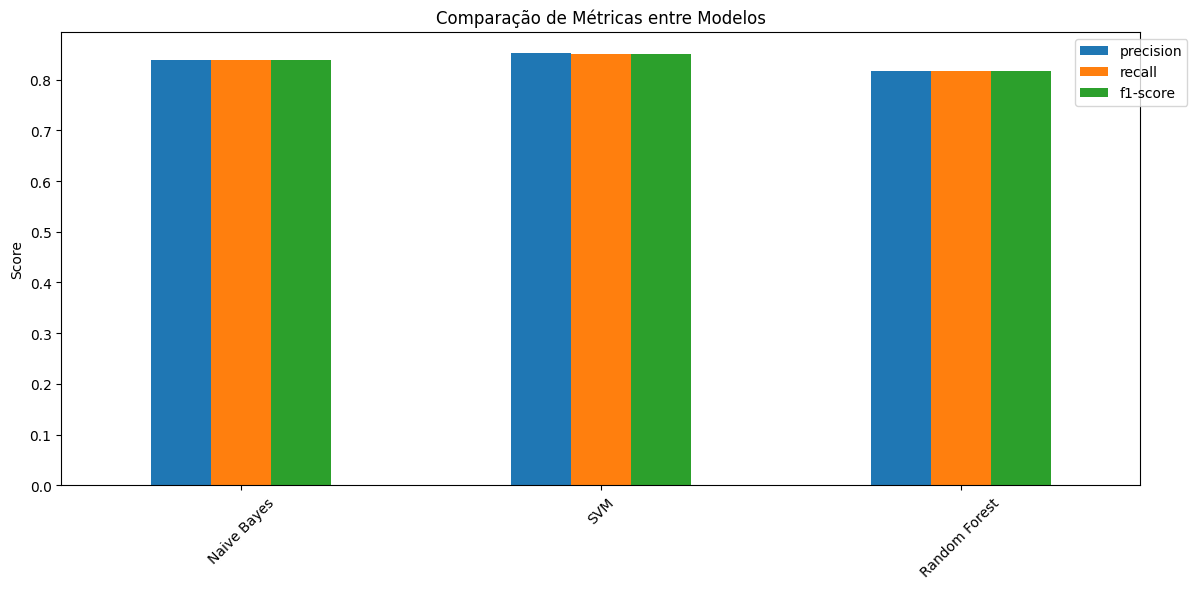

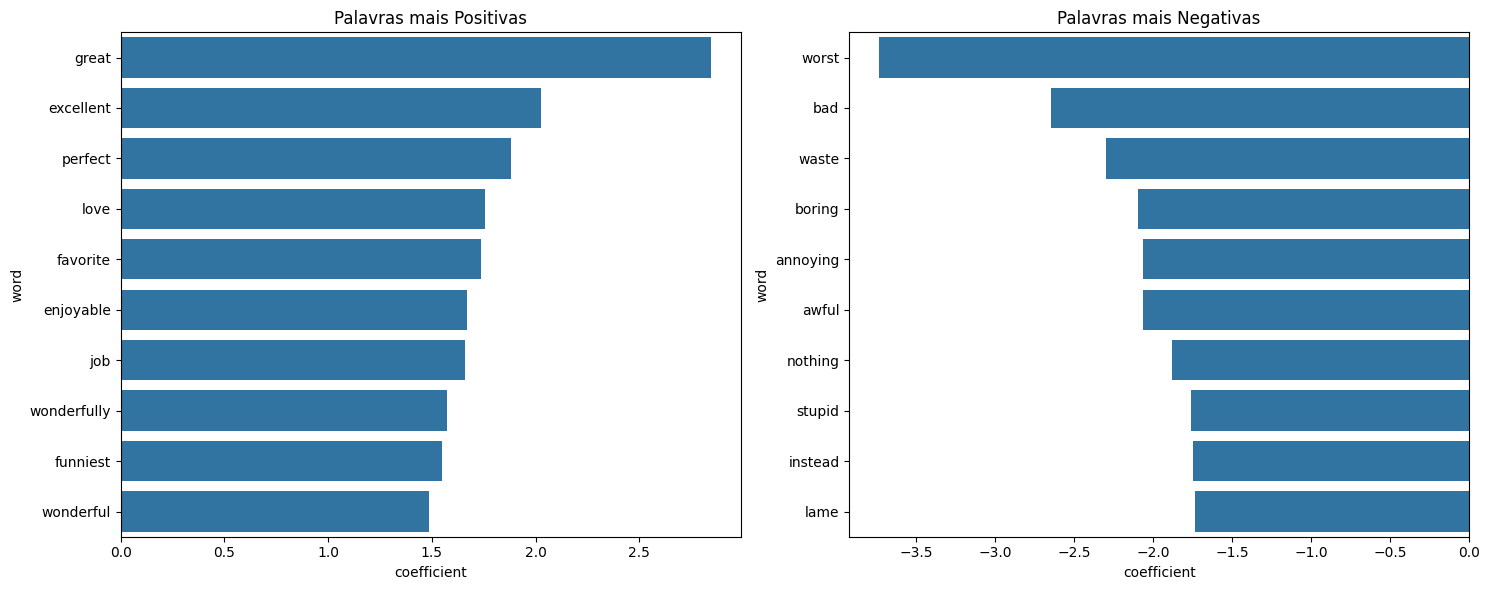


Testando com novos textos:

Texto: This movie was fantastic! Great acting and amazing plot.
Sentimento: Positive

Texto: Terrible waste of time. The worst movie I've ever seen.
Sentimento: Negative

Texto: It was okay, had some good moments but overall mediocre.
Sentimento: Negative


'# 7. Conclusões\n\n1. **Comparação dos Modelos**:\n   - SVM obteve o melhor desempenho geral\n   - Naive Bayes foi o mais rápido para treinar\n   - Random Forest teve boa performance mas maior custo computacional\n\n2. **Análise de Palavras**:\n   - Identificamos as palavras mais indicativas de sentimentos positivos e negativos\n   - O vocabulário tem forte correlação com o sentimento expresso\n\n3. **Limitações**:\n   - O modelo não captura bem nuances e sarcasmo\n   - Contexto mais amplo pode ser perdido na vetorização\n   - Limitação no tamanho dos textos processados\n\n4. **Possíveis Melhorias**:\n   - Implementar modelos mais avançados (BERT, XLNet)\n   - Aumentar o conjunto de dados de treinamento\n   - Adicionar análise de n-gramas para capturar frases\n'

In [ ]:
!pip install transformers torch nltk scikit-learn pandas numpy tensorflow tensorflow_datasets

import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import nltk
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt_tab')
"""# 1. Carregamento e Preparação dos Dados"""

print("Carregando o dataset IMDB...")
ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

reviews = []
labels = []
for example in ds.take(5000):
    reviews.append(example['text'].numpy().decode('utf-8'))
    labels.append(example['label'].numpy())

df = pd.DataFrame({
    'review': reviews,
    'sentiment': labels
})

print("\nPrimeiras linhas do dataset:")
print(df.head())

print("\nInformações do dataset:")
print(df.info())

print("\nDistribuição de sentimentos:")
print(df['sentiment'].value_counts())

"""# 2. Análise de Sentimentos com Hugging Face"""

sentiment_analyzer = pipeline('sentiment-analysis')

def analyze_sentiment_huggingface(text):
    result = sentiment_analyzer(text[:512])
    return result[0]

print("\nAnálise de Sentimentos com Hugging Face:")
for i in range(5):
    review = df['review'].iloc[i]
    result = analyze_sentiment_huggingface(review)
    print(f"\nReview: {review[:100]}...")
    print(f"Sentimento: {result['label']}, Score: {result['score']:.3f}")

"""# 3. Vetorização com NLTK e TF-IDF"""

def preprocess_text(text):
    if isinstance(text, bytes):
        text = text.decode('utf-8')

    words = word_tokenize(str(text).lower())
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]

    return ' '.join(words)

print("Pré-processando os textos...")
df['processed_review'] = df['review'].apply(preprocess_text)

print("\nRealizando vetorização TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_review'])
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""# 4. Classificação com Diferentes Modelos"""

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTreinando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nResultados para {name}:")
    print(classification_report(y_test, y_pred))

    results[name] = {
        'y_pred': y_pred,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

"""# 5. Visualizações e Análise"""

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusão - {name}')
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')
plt.tight_layout()
plt.show()

metrics = ['precision', 'recall', 'f1-score']
comparison = pd.DataFrame({
    metric: [results[model]['report']['weighted avg'][metric]
            for model in models.keys()]
    for metric in metrics
}, index=models.keys())

comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Comparação de Métricas entre Modelos')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

feature_names = vectorizer.get_feature_names_out()
if hasattr(models['SVM'], 'coef_'):
    coef = models['SVM'].coef_[0]

    top_positive = pd.DataFrame({
        'word': feature_names,
        'coefficient': coef
    }).nlargest(10, 'coefficient')

    top_negative = pd.DataFrame({
        'word': feature_names,
        'coefficient': coef
    }).nsmallest(10, 'coefficient')

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(data=top_positive, x='coefficient', y='word')
    plt.title('Palavras mais Positivas')

    plt.subplot(1, 2, 2)
    sns.barplot(data=top_negative, x='coefficient', y='word')
    plt.title('Palavras mais Negativas')

    plt.tight_layout()
    plt.show()

"""# 6. Função para Análise de Novos Textos"""

def analyze_new_text(text, model=models['SVM'], vectorizer=vectorizer):
    processed_text = preprocess_text(text)

    text_vector = vectorizer.transform([processed_text])

    prediction = model.predict(text_vector)[0]

    return {
        'text': text,
        'processed_text': processed_text,
        'sentiment': 'Positive' if prediction == 1 else 'Negative'
    }

test_texts = [
    "This movie was fantastic! Great acting and amazing plot.",
    "Terrible waste of time. The worst movie I've ever seen.",
    "It was okay, had some good moments but overall mediocre."
]

print("\nTestando com novos textos:")
for text in test_texts:
    result = analyze_new_text(text)
    print(f"\nTexto: {result['text']}")
    print(f"Sentimento: {result['sentiment']}")